# Process Data From Kaggle

In [1]:
# https://www.kaggle.com/datasets/adilshamim8/predict-calorie-expenditure
import pandas as pd
import numpy as np

def get_data(file_path, sex_to_include="male"):
    with open(file_path) as file:
        csvFile = pd.read_csv(file)
        df = pd.DataFrame(csvFile)
        sex = df["Sex"]    
        age = df["Age"]
        height = df["Height"]
        weight = df["Weight"]
        duration = df["Duration"]
        heart_rate = df["Heart_Rate"]
        body_temp = df["Body_Temp"]
        calories = df["Calories"]
    
    # include_sex = sex_to_include == "male" or sex_to_include == "female"

    x = []
    y = []
    for i in range(len(calories)):
        if not sex[i] == sex_to_include:
            continue
        data_to_append = [age[i], height[i], weight[i], duration[i], heart_rate[i], body_temp[i]]
        # if include_sex:
        #     data_to_append.append(sex[i])
        x.append(data_to_append)
        y.append(calories[i])

    return np.array(x), np.array(y)

# My Regression Code
The following code solves the normal equations directly in order find the theta coefficients for a linear regression model

In [2]:
def calculate_X(x_data, y_data):
    if len(x_data.shape) < 2:
        x_data = np.atleast_2d(x_data).reshape((x_data.shape[0], 1))
    n=y_data.shape[0]
    p=x_data.shape[1]
    X = np.zeros((n, p+1), dtype=float)
    
    for i in range(n):
        X[i, :] = np.array([1] + list(x_data[i]))
    return X

def calculate_theta_hat(x_data, y_data):
    X = calculate_X(x_data, y_data)
    return np.linalg.inv(X.T@X)@X.T@y_data
    # return np.linalg.pinv(X)@y_data

def calculate_y_hat(x, theta):
    x = np.array(x)
    if len(x.shape) < 2:
        x = np.atleast_2d(x).reshape((x.shape[0], 1))
    m = x.shape[0]
    y_hat = np.zeros((m,), dtype=float)
    for i in range(m):
        y_hat[i] = theta[0] + np.dot(theta[1:], x[i])
    return y_hat

# Convencience Class For Normalizing and Plotting Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random


class Predictor:
    """
    I made this to translate between non-normalized queries, using a normalized model.
    """
    def __init__(self, X: list, y: list, classifier):
        X = np.array(X)
        X_normalized = self.normalize_training_data(X)
        
        self.classifier = classifier
        self.classifier.fit(X_normalized, y)
    
    def normalize_training_data(self, X):
        X = np.array(X)
        num_feature_types = X.shape[1]
        new_X = np.zeros_like(X)
        min_max_values = np.zeros((X.shape[1], 2))

        for i in range(num_feature_types):
            new_X[:, i] = (X[:, i] - np.min(X[:, i])) / (np.max(X[:, i]) - np.min(X[:, i]))
            min_max_values[i, 0] = np.min(X[:, i])
            min_max_values[i, 1] = np.max(X[:, i])
        
        self.min_max_training_values = min_max_values

        return new_X
    
    def normalize_test_data(self, X):
        X = np.array(X)
        num_feature_types = X.shape[1]
        new_X = np.zeros_like(X)

        for i in range(num_feature_types):
            new_X[:, i] = (X[:, i] - self.min_max_training_values[i, 0]) / (self.min_max_training_values[i, 1] - self.min_max_training_values[i, 0])
        
        return new_X

    def predict(self, X):
        X_normalized = self.normalize_test_data(X)
        return self.classifier.predict(X_normalized)

    def sparse_scatter_3d(self, ax, x_data, y_data, proportion=0.01, color="blue"):
        sparse_data_indices = random.sample([i for i in range(y_data.shape[0])], int(proportion*y_data.shape[0]))
        sparse_x_data = x_data[sparse_data_indices]
        sparse_y_data = y_data[sparse_data_indices]
        ax.scatter(sparse_x_data[:, 0], sparse_x_data[:, 1], sparse_y_data, color=color)

    def plot_3d(self, ax, x1, x2, color="blue"):
        @np.vectorize
        def _calculate_z(x, y):
            return self.predict([[x, y]])[0]

        X, Y = np.meshgrid(x1, x2)
        Z = _calculate_z(X, Y)

        ax.plot_surface(X, Y, Z, color=color)
    
    def calculate_mse(self, x_data, y_data):
        num_data_points = y_data.shape[0]
        total_squared_error = 0
        for i in range(num_data_points):
            total_squared_error += (y_data[i] - self.predict(np.array([x_data[i]])))**2

        mean_squared_error = total_squared_error / num_data_points
        return mean_squared_error

def scatter_sparse(ax, x, y, proportion=0.01):
    _indices = random.sample([i for i in range(y.shape[0])], int(proportion*y.shape[0]))
    ax.scatter(x[_indices], y[_indices])

# Filter Raw Data

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

male_x, male_y = get_data("archive/train.csv", "male")
female_x, female_y = get_data("archive/train.csv", "female")
male_x, male_x_test, male_y, male_y_test = train_test_split(male_x, male_y, test_size=0.2)


In [5]:
heart_rate = male_x[:, 4]
heart_rate_test = male_x_test[:, 4]

duration = male_x[:, 3]
duration_test = male_x_test[:, 3]

male_x_2d = np.array([[hr, d] for hr, d in zip(heart_rate, duration)])
male_x_2d_test = np.array([[hr, d] for hr, d in zip(heart_rate_test, duration_test)])

In [18]:
len(male_x_2d_test)

74856

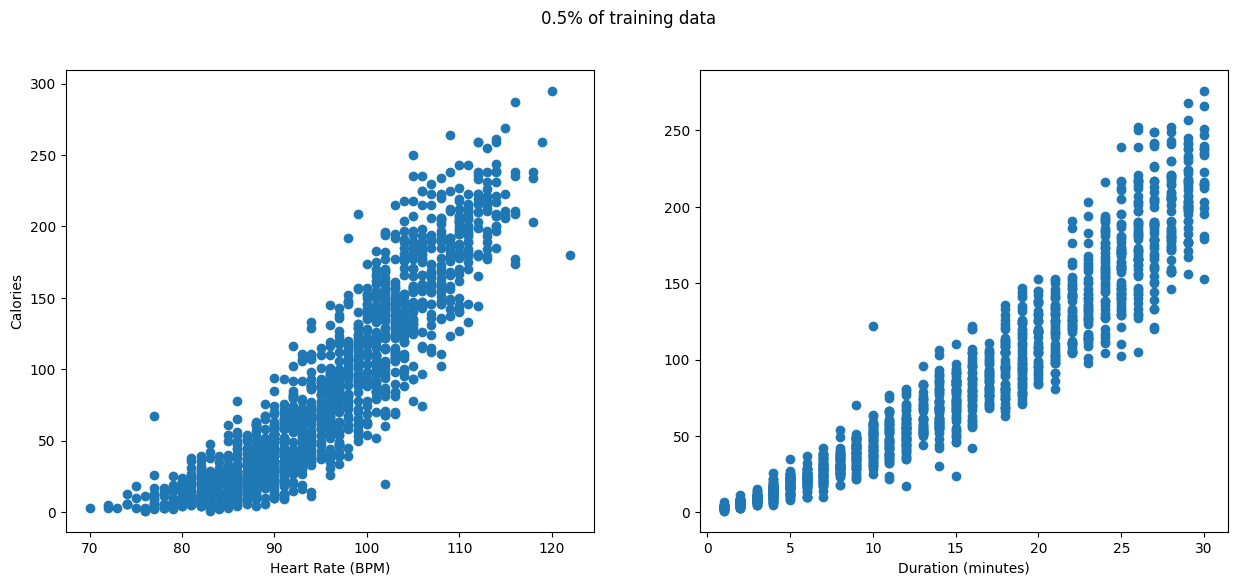

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

proportion = 0.005
scatter_sparse(ax1, heart_rate, male_y, proportion=proportion)
ax1.set_xlabel("Heart Rate (BPM)")
ax1.set_ylabel("Calories")
scatter_sparse(ax2, duration, male_y, proportion=proportion)
ax2.set_xlabel("Duration (minutes)")

fig.suptitle(f"{100*proportion}% of training data")
plt.show()

## Train Scikit-learn Model

In [7]:
from sklearn.linear_model import LinearRegression


scikit_regressor = LinearRegression()
scikit_predictor = Predictor(male_x_2d, male_y, scikit_regressor)

scikit_theta_0 = scikit_predictor.classifier.intercept_
scikit_thetas = [float(_theta) for _theta in [scikit_theta_0] + list(scikit_predictor.classifier.coef_)]
print(f"Scikit-Learn Predicted Theta Values {scikit_thetas}")

Scikit-Learn Predicted Theta Values [-50.443919383305214, 135.93390378479242, 153.31441805882324]


In [21]:
from sklearn.metrics import mean_squared_error
y_true = male_y
y_predicted = scikit_predictor.predict(male_x_2d)
mean_squared_error(y_true, y_predicted)

336.67463500642

## Train my model by solving Normal Equations

In [8]:
def normalize_training_data(X):
    X = np.array(X)
    num_feature_types = X.shape[1]
    new_X = np.zeros_like(X)
    min_max_values = np.zeros((X.shape[1], 2))

    for i in range(num_feature_types):
        new_X[:, i] = (X[:, i] - np.min(X[:, i])) / (np.max(X[:, i]) - np.min(X[:, i]))
        min_max_values[i, 0] = np.min(X[:, i])
        min_max_values[i, 1] = np.max(X[:, i])
    
    min_max_training_values = min_max_values

    return new_X, min_max_training_values

def normalize_test_data(X, min_max_training_values):
    X = np.array(X)
    num_feature_types = X.shape[1]
    new_X = np.zeros_like(X)

    for i in range(num_feature_types):
        new_X[:, i] = (X[:, i] - min_max_training_values[i, 0]) / (min_max_training_values[i, 1] - min_max_training_values[i, 0])
    
    return new_X

male_x_2d_normalized, min_max_training_values = normalize_training_data(male_x_2d)


my_thetas = calculate_theta_hat(male_x_2d_normalized, male_y)
print(f"Theta Values from solving normal equations directly {my_thetas}")

Theta Values from solving normal equations directly [-50.44391938 135.93390378 153.31441806]


In [9]:
print(f"Theta Values From Scikit-Learn {scikit_thetas}")
print(f"Theta Values Directly From Normal Equations {my_thetas}")

Theta Values From Scikit-Learn [-50.443919383305214, 135.93390378479242, 153.31441805882324]
Theta Values Directly From Normal Equations [-50.44391938 135.93390378 153.31441806]


# I wrap up my direct model in a class for convenience

In [10]:
class MyLinearRegressor:
    def __init__(self):
        pass

    def fit(self, x_data, y_data):
        self.theta_hat = calculate_theta_hat(x_data, y_data)

    def predict(self, x):
        return calculate_y_hat(x, self.theta_hat)

my_regressor = MyLinearRegressor()
my_predictor = Predictor(male_x_2d, male_y, my_regressor)

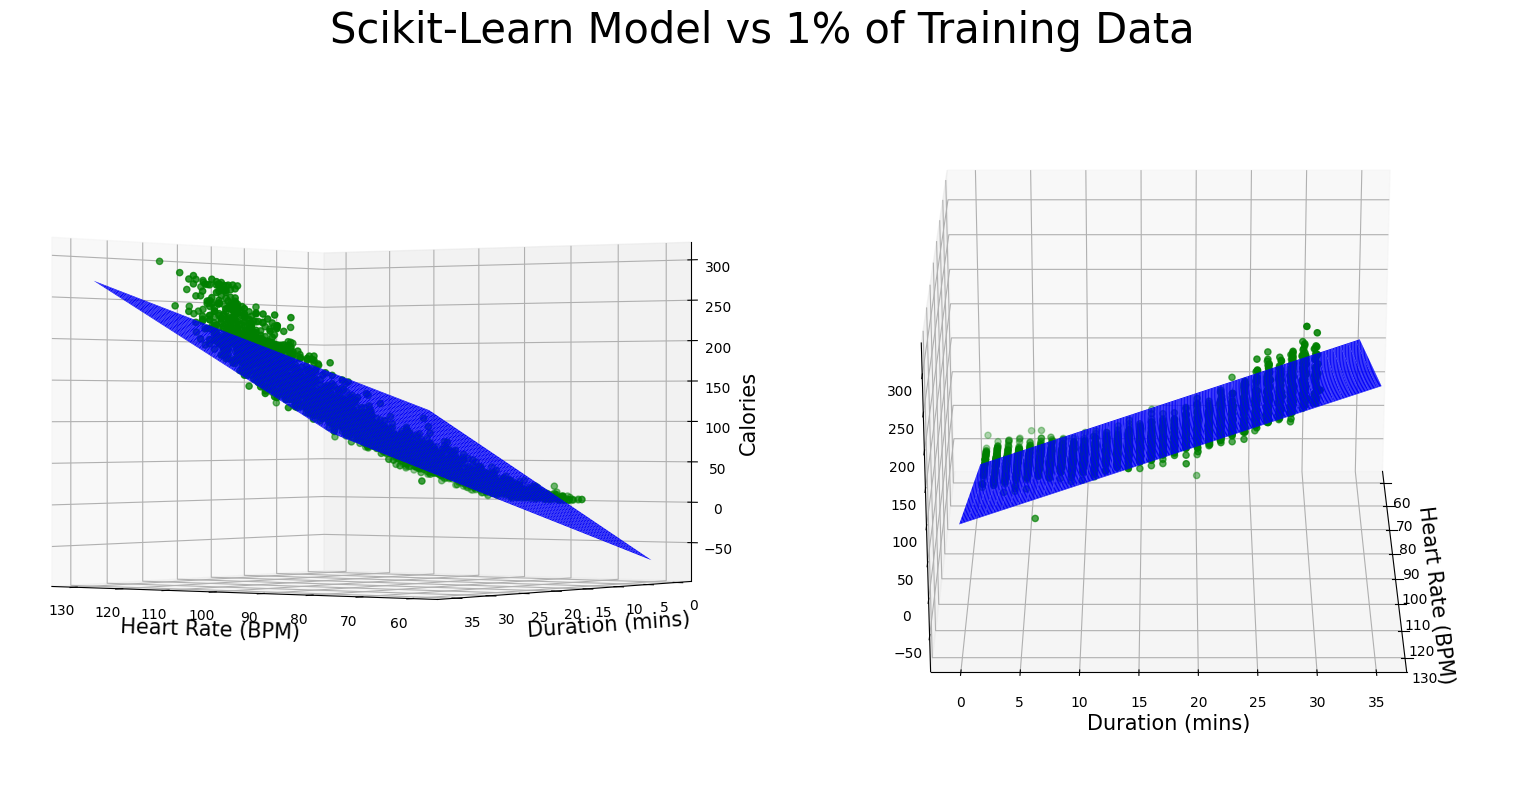

In [11]:
fig = plt.figure(figsize=(16,8))
label_fontsize = 15
# First subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
x1 = np.linspace(60, 130, 100)
x2 = np.linspace(0, 35, 100)

scikit_predictor.plot_3d(ax1, x1, x2, color="blue")
scikit_predictor.sparse_scatter_3d(ax1, male_x_2d, male_y, color="green")
ax1.view_init(0, 125, 0)
ax1.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax1.set_ylabel("Duration (mins)", fontsize=label_fontsize)
ax1.set_zlabel("Calories", fontsize=label_fontsize)


ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scikit_predictor.plot_3d(ax2, x1, x2, color="blue")
scikit_predictor.sparse_scatter_3d(ax2, male_x_2d, male_y, color="green")
# ax.view_init(22, 0, 0)
ax2.view_init(24, 0, 0)
ax2.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax2.set_ylabel("Duration (mins)", fontsize=label_fontsize)
# ax2.set_zlabel("Calories", fontsize=label_fontsize)

fig.suptitle("Scikit-Learn Model vs 1% of Training Data", fontsize=30)
plt.tight_layout()

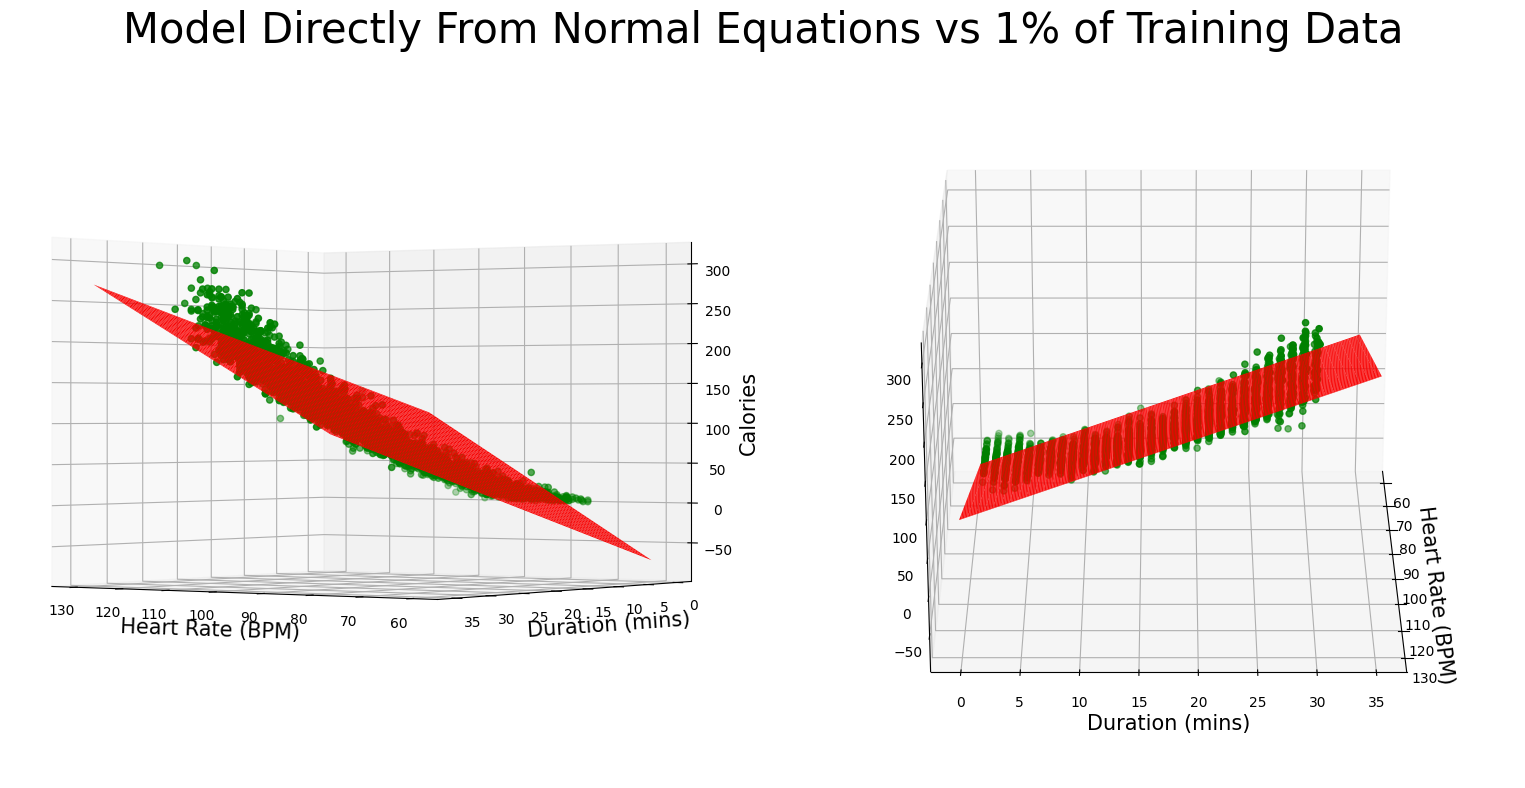

In [12]:
fig = plt.figure(figsize=(16,8))
label_fontsize = 15
# First subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
x1 = np.linspace(60, 130, 100)
x2 = np.linspace(0, 35, 100)

my_predictor.plot_3d(ax1, x1, x2, color="red")
my_predictor.sparse_scatter_3d(ax1, male_x_2d, male_y, color="green")
ax1.view_init(0, 125, 0)
ax1.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax1.set_ylabel("Duration (mins)", fontsize=label_fontsize)
ax1.set_zlabel("Calories", fontsize=label_fontsize)


ax2 = fig.add_subplot(1, 2, 2, projection='3d')
my_predictor.plot_3d(ax2, x1, x2, color="red")
my_predictor.sparse_scatter_3d(ax2, male_x_2d, male_y, color="green")
# ax.view_init(22, 0, 0)
ax2.view_init(24, 0, 0)
ax2.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax2.set_ylabel("Duration (mins)", fontsize=label_fontsize)
# ax2.set_zlabel("Calories", fontsize=label_fontsize)

fig.suptitle("Model Directly From Normal Equations vs 1% of Training Data", fontsize=30)
plt.tight_layout()

In [13]:
scikit_mse_train = scikit_predictor.calculate_mse(male_x_2d, male_y)
scikit_mse_test = scikit_predictor.calculate_mse(male_x_2d_test, male_y_test)

print(f"MSE Train (Scikit): {scikit_mse_train}")
print(f"MSE Test (Scikit): {scikit_mse_test}")

MSE Train (Scikit): [336.67463501]
MSE Test (Scikit): [334.16997199]


In [14]:
my_mse_train = my_predictor.calculate_mse(male_x_2d, male_y)
my_mse_test = my_predictor.calculate_mse(male_x_2d_test, male_y_test)

print(f"MSE Train (Direct Model): {my_mse_train}")
print(f"MSE Test (Direct Model): {my_mse_test}")

MSE Train (Direct Model): [336.67463501]
MSE Test (Direct Model): [334.16997199]


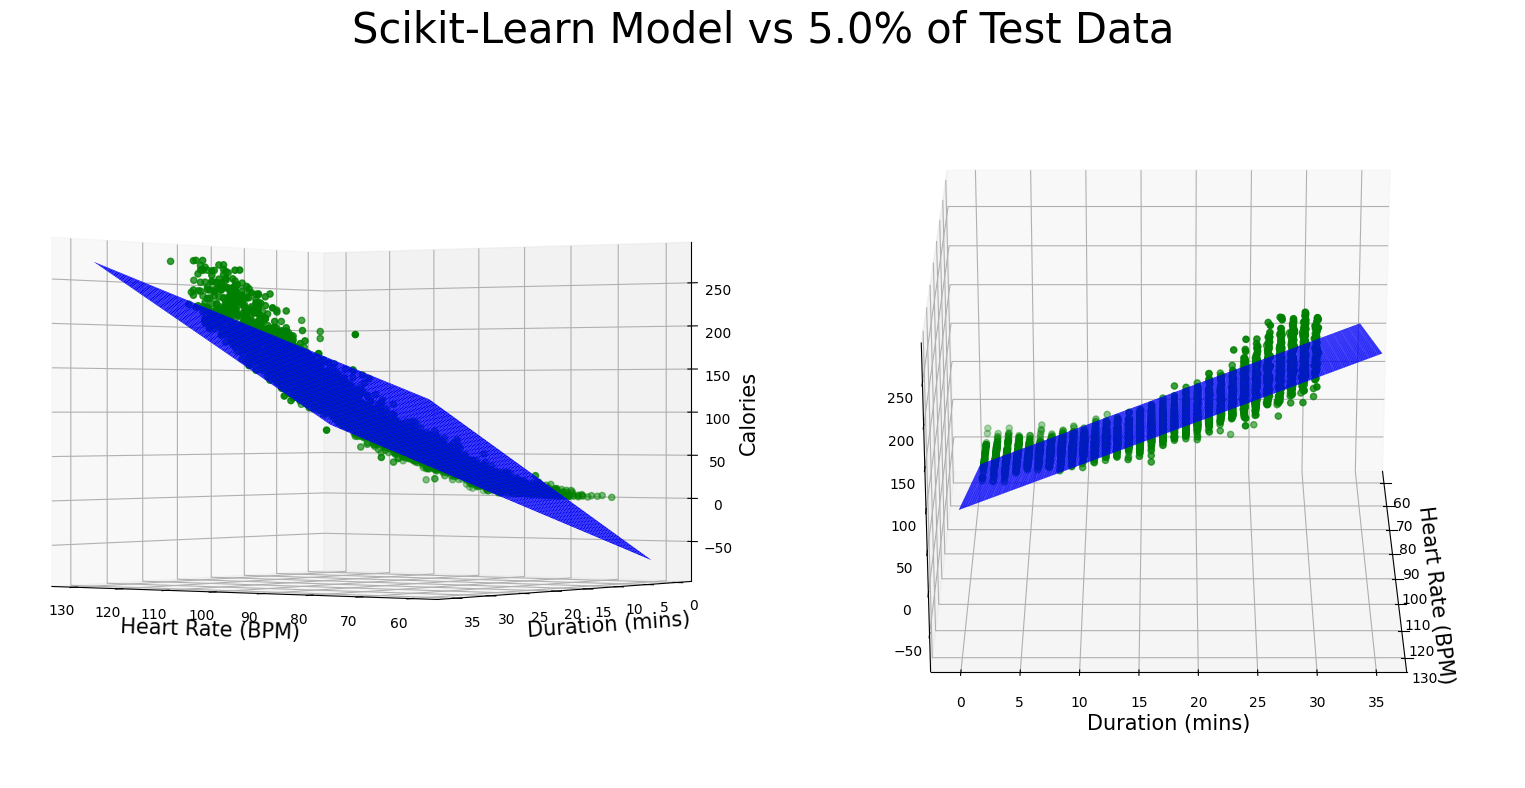

In [15]:
fig = plt.figure(figsize=(16,8))
label_fontsize = 15
# First subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
x1 = np.linspace(60, 130, 100)
x2 = np.linspace(0, 35, 100)

proportion = 0.05

scikit_predictor.plot_3d(ax1, x1, x2, color="blue")
scikit_predictor.sparse_scatter_3d(ax1, male_x_2d_test, male_y_test, color="green", proportion=proportion)
ax1.view_init(0, 125, 0)
ax1.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax1.set_ylabel("Duration (mins)", fontsize=label_fontsize)
ax1.set_zlabel("Calories", fontsize=label_fontsize)


ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scikit_predictor.plot_3d(ax2, x1, x2, color="blue")
scikit_predictor.sparse_scatter_3d(ax2, male_x_2d_test, male_y_test, color="green", proportion=proportion)
# ax.view_init(22, 0, 0)
ax2.view_init(24, 0, 0)
ax2.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax2.set_ylabel("Duration (mins)", fontsize=label_fontsize)
# ax2.set_zlabel("Calories", fontsize=label_fontsize)

fig.suptitle(f"Scikit-Learn Model vs {100*proportion}% of Test Data", fontsize=30)
plt.tight_layout()

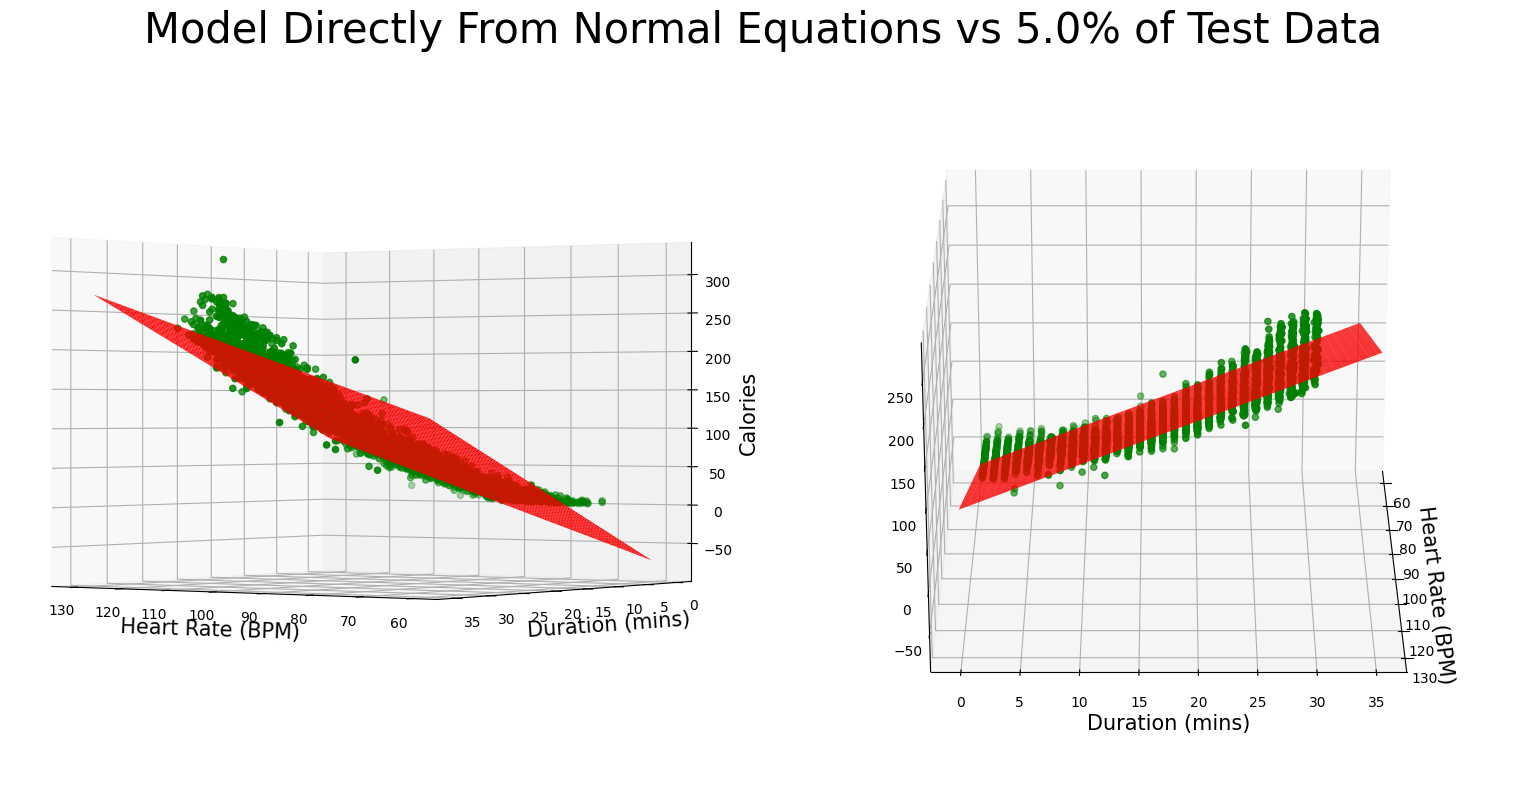

In [16]:
fig = plt.figure(figsize=(16,8))
label_fontsize = 15
# First subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
x1 = np.linspace(60, 130, 100)
x2 = np.linspace(0, 35, 100)

proportion = 0.05

my_predictor.plot_3d(ax1, x1, x2, color="red")
my_predictor.sparse_scatter_3d(ax1, male_x_2d_test, male_y_test, color="green", proportion=proportion)
ax1.view_init(0, 125, 0)
ax1.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax1.set_ylabel("Duration (mins)", fontsize=label_fontsize)
ax1.set_zlabel("Calories", fontsize=label_fontsize)


ax2 = fig.add_subplot(1, 2, 2, projection='3d')
my_predictor.plot_3d(ax2, x1, x2, color="red")
my_predictor.sparse_scatter_3d(ax2, male_x_2d_test, male_y_test, color="green", proportion=proportion)
# ax.view_init(22, 0, 0)
ax2.view_init(24, 0, 0)
ax2.set_xlabel("Heart Rate (BPM)", fontsize=label_fontsize)
ax2.set_ylabel("Duration (mins)", fontsize=label_fontsize)
# ax2.set_zlabel("Calories", fontsize=label_fontsize)

fig.suptitle(f"Model Directly From Normal Equations vs {100*proportion}% of Test Data", fontsize=30)
plt.tight_layout()